# Debiasing Notebook

This notebook takes in binned and cleaned Galaxy Zoo data and produces a debiased output catalogue. This notebook is based on the procedure outlined in [Hart et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.461.3663H/abstract), and original debiasing efforts hosted on the GAMA branch of [this GitHub repo](https://github.com/RossHart/Debiasing/tree/GAMA).

In [1]:
# imports
import os
import sys
import warnings
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import (
    AnchoredSizeBar as scalebar
)
from collections import Counter as counter
import scipy.stats as st
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic, gaussian_kde
from scipy.optimize import minimize, curve_fit
import copy
import astropy.stats as stats
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import imageio
import time
from sklearn.neighbors import NearestNeighbors
from voronoi_2d_binning import voronoi_2d_binning

# Notebook startup
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}
nbtf = '%Y-%m-%d %H:%M:%S %Z'
nbt0 = time.time()
nbt0str = time.strftime(nbtf, time.localtime(nbt0))
print(f'Notebook start time: \n   {nbt0str}')
#--------------------------------68-------------------------------->
# np.seterr(divide='raise')

Notebook start time: 
   2020-10-09 17:58:53 CDT


## Configuration Parameters

Here we define parameters which will be used throughout the remainder of this notebook.

In [2]:
# data locations (original output: gz_gama_2018-02-25_debiased.fits)
outdir = os.path.abspath('.')
input_votefrac_cat = f'{outdir}/../gkgz-cleaned.fits.gz'
input_extraval_cat = f'{outdir}/../gkgz-extra.fits.gz'
output_cat = f'{outdir}/../gkgz-debiased.fits.gz'

# column suffix info
input_total_suffix = '_clean_total'
input_frac_suffix = '_clean_frac'
output_frac_suffix = '_deb_frac'
output_priorsample_suffix = '_deb_psamp'

# data column names
R50_column = 'GALRE_r_kpc'
Mr_column = 'absmag_r'
z_column = 'Z_TONRY'
input_votefrac_ID = 'gama_cataid'
input_extraval_ID = 'CATAID'

# Half-light radius (R50) and absolute magnitude (Mr) quality cuts
R50lo = 0.4
R50hi = 25
Mrlo = -23
Mrhi = -15

# astrophysical limits
survey_mag_limit = 19.8
volume_redshift_bounds = (0.02, 0.15)

# prior p cut values
p_cut = 0.5
N_cut = 5
null_value = -1

# debiasing sample binning target values
n_voronoi = 30
n_per_z = 50
low_signal_limit = 100
clip_percentile = 5
null_value = -1

# debiasing function boundary limits
logistic_bounds = ((0.5, 10), (-10, 10))
exponential_bounds = ((10**(-5), 10), (10**(-5), 10))
log_fv_range = (-1.5, 0.01)

# plotting variables
dpi = 300
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
cols[0],cols[1] = cols[1],cols[0]

## Read in Data, Initial Setup

First, we read in the GAMA cleaned, binned and extra information datasets. Simple analysis is performed, to verify the input data.

In [3]:
# z to dist
def z_to_dist(z):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    return cosmo.luminosity_distance(z)

In [4]:
# mag to Mag
def mag_to_Mag(mag, z):
    D = z_to_dist(z)
    Mag = mag - 5*(np.log10(D/(u.pc))-1)
    return Mag

In [5]:
# read in tabular data
gama_cln = Table.read(input_votefrac_cat)
gama_ext = Table.read(input_extraval_cat)
if any(gama_cln[input_votefrac_ID] != gama_ext[input_extraval_ID]):
    raise ValueError("input catalogues must be row matched!")

In [6]:
# generate primary data table
R50 = gama_ext[R50_column]
Mr = gama_ext[Mr_column]
z = gama_ext[z_column]
data = gama_cln.copy()
for c in (Mr_column, R50_column, z_column):
    data[c] = gama_ext[c]
# znums = dict()
# for zlo,zhi in zip(volume_redshift_bounds[:-1],
#                    volume_redshift_bounds[1:]):
#     key = f'{round(zlo,5)} ≤ z ≤ {round(zhi,5)}'
#     value = sum((z>=zlo) & (z<=zhi))
#     znums.update({key:value})
# print(f'redshift bin number counts:')
# display(znums)

In [7]:
# visualise first couple of objects in data table
oldnrows = pd.options.display.max_rows
pd.options.display.max_rows = 100
display(data.to_pandas().head(2).T)
pd.options.display.max_rows = oldnrows

,0,1
subject_id,b'5857c4a3d369fd0040000001',b'5857c4a3d369fd0040000003'
gama_cataid,598860,598875
zooniverse_id,b'AGZ000dir0',b'AGZ000dir2'
features_clean_total,24.2226,30.2618
edgeon_clean_total,1.73966,2.6479
bar_clean_total,1.73966,2.47801
spiral_clean_total,1.73966,2.47801
bulge_clean_total,1.73966,2.47801
spiralwinding_clean_total,0,1
spiralnumber_clean_total,0,1


In [8]:
# 2D kernel density estimator
def kde2d(x, y, xlim = None, ylim = None, nx = 25, ny = 25,
          sigma = None, xlog = False, ylog = False,
          levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]):
    """2D kernel density estimator."""
    old = np.seterr(invalid='ignore')
    xlim = [np.nanmin(x), np.nanmax(x)] if xlim is None else xlim
    ylim = [np.nanmin(y), np.nanmax(y)] if ylim is None else ylim
    if xlog:
        x = np.log10(x)
        xlim = np.log10(xlim)
    if ylog:
        y = np.log10(y)
        ylim = np.log10(ylim)
    bins = [int(nx), int(ny)]
    range = [sorted(np.asarray(xlim)), sorted(np.asarray(ylim))]
    Z, X, Y = np.histogram2d(x, y, bins, range)
    if xlog:
        X = 10**X
    if ylog:
        Y = 10**Y
    X = (X[1:] + X[:-1]) / 2
    Y = (Y[1:] + Y[:-1]) / 2
    sigma=[np.sqrt(nx)/5,np.sqrt(ny)/5] if sigma is None else sigma
    Z = gaussian_filter(Z, sigma)
    L = []
    if levels:
        V = sorted(np.ravel(Z))
        C = np.cumsum(V)
        for lvl in levels:
            L.append(V[np.abs(C - (C[-1]*lvl)).argmin()])
    np.seterr(**old)
    return X, Y, Z.T, [xlim, ylim], L

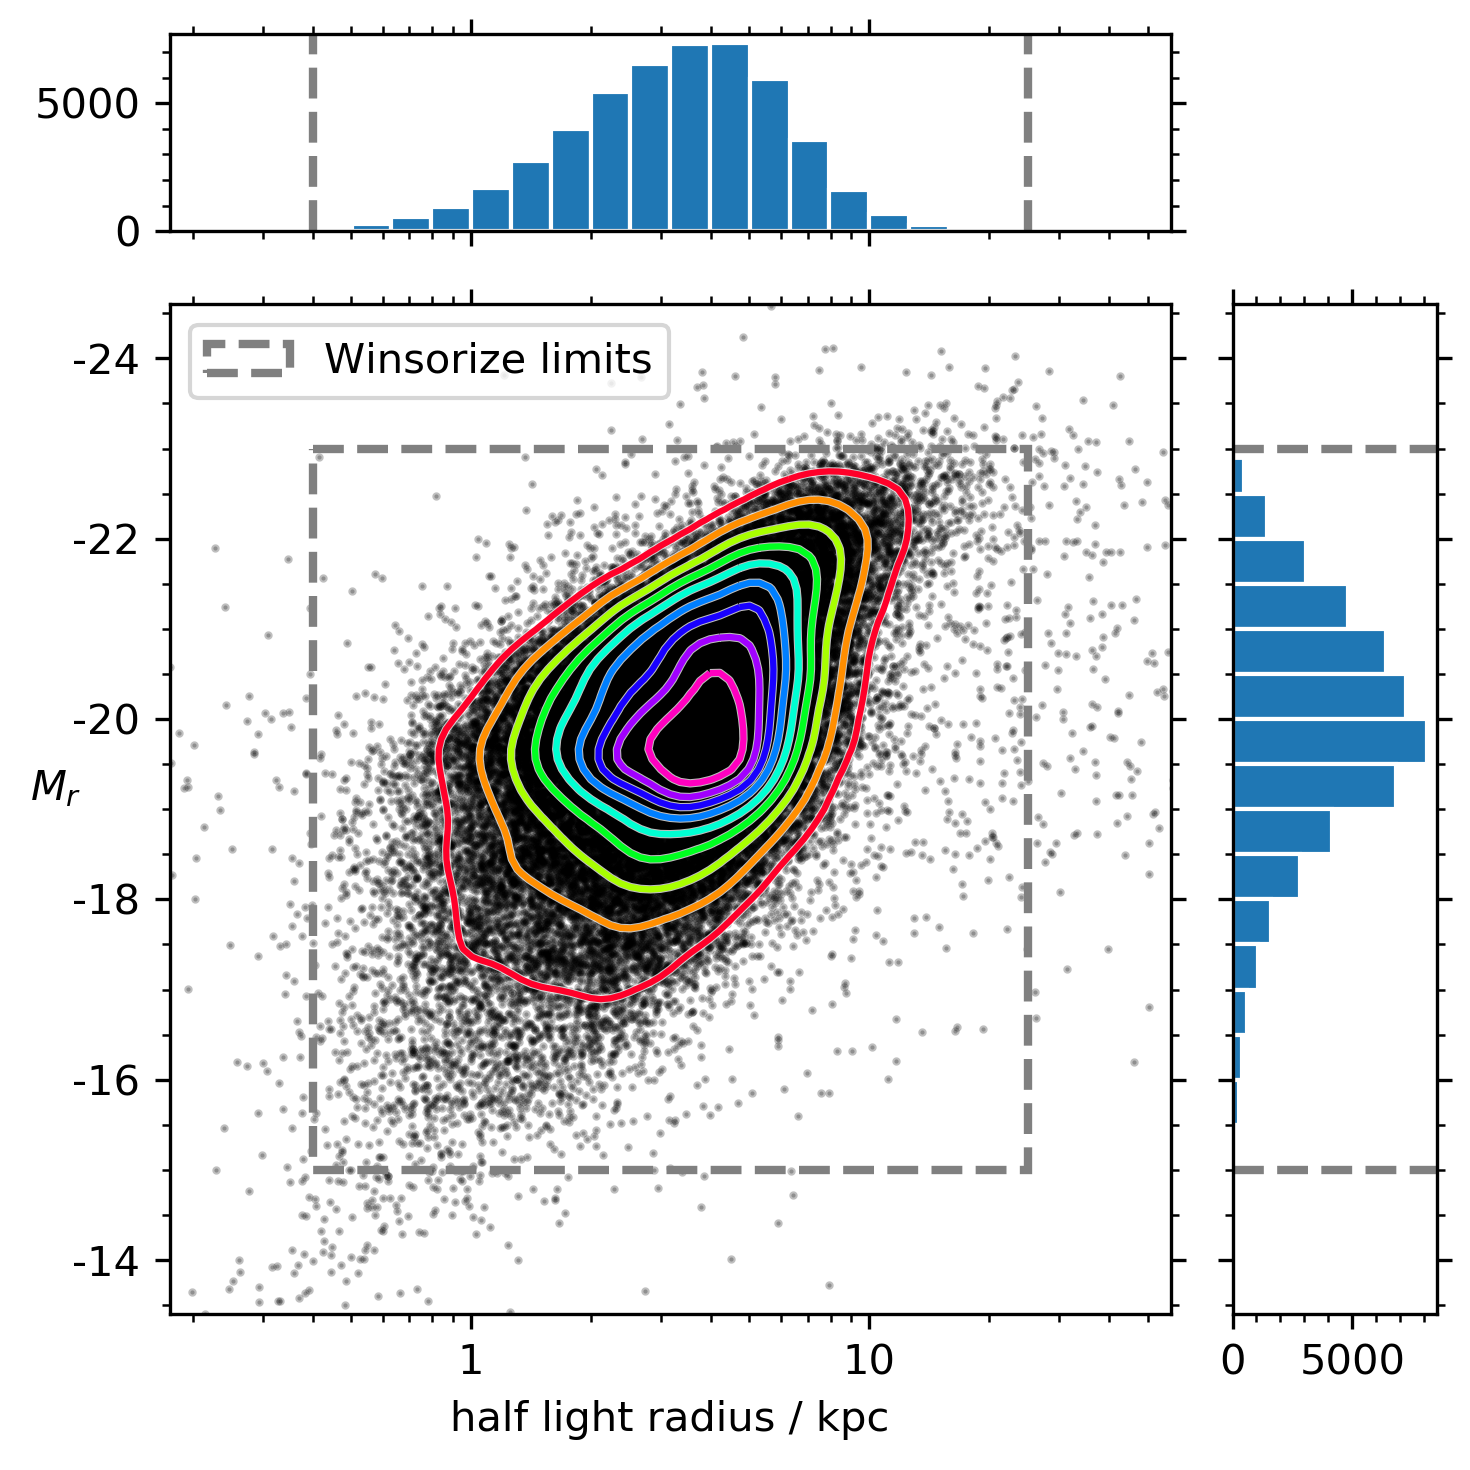

In [9]:
# size-magnitude plot
def minmax(x): return [np.nanmin(x), np.nanmax(x)]
def extendrange(x,f=0.05):u,v=minmax(x);d=(v-u)*(1+f);return v-d,u+d
size = gama_ext[R50_column]
mag = gama_ext[Mr_column]
winsorColor = 'grey'
sizeLim = [R50lo,R50hi]
magLim = [Mrlo,Mrhi]
outerSizeLim = 10**np.array(extendrange(np.log10(sizeLim), f=0.2))
outerMagLim = extendrange(magLim, f=0.2)[::-1]
X, Y, Z, extent, L = kde2d(size, mag, outerSizeLim, outerMagLim,
                           xlog=True, nx=101, ny=101)

fig = plt.figure(figsize=(5,5), dpi=dpi)
gs = matplotlib.gridspec.GridSpec(5, 5, figure=fig)
fmt = matplotlib.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))

ax = fig.add_subplot(gs[-4:,:4])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
ax.scatter(size, mag, c='k', s=1, alpha=0.25, label='')
ax.contour(X, Y, Z, L, colors='white', alpha=0.75, linewidths=2)
ax.contour(X, Y, Z, L, cmap='gist_rainbow', alpha=1)
rect = matplotlib.patches.Rectangle((sizeLim[0], magLim[0]),
                                    np.diff(sizeLim),
                                    np.diff(magLim),
                                    linewidth=2,
                                    edgecolor=winsorColor,
                                    facecolor='none',
                                    linestyle='--', 
                                    label='Winsorize limits',)
ax.add_patch(rect)
ax.set_xscale('log')
ax.set_xlabel('half light radius / kpc')
ax.set_ylabel('$M_r$', rotation=0)
ax.set_xlim(outerSizeLim)
ax.set_ylim(outerMagLim)
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.legend(loc='upper left')

ax = fig.add_subplot(gs[0,:4])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
ax.set_xlim(outerSizeLim)
ax.hist(size, bins=np.logspace(-3, 4, 71), log=False, label='',
        edgecolor='white', color=cols[1])
plt.axvline(sizeLim[0], c='white', ls='-', lw=5)
plt.axvline(sizeLim[1], c='white', ls='-', lw=5)
plt.axvline(sizeLim[0], c=winsorColor, ls='--', lw=2)
plt.axvline(sizeLim[1], c=winsorColor, ls='--', lw=2)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.set_xticklabels([])

ax = fig.add_subplot(gs[-4:,4])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
ax.set_ylim(outerMagLim)
ax.hist(mag, bins=np.arange(-30,-9,0.5), log=False, label='',
        edgecolor='white', color=cols[1], orientation='horizontal')
plt.axhline(magLim[0], c='white', ls='-', lw=5)
plt.axhline(magLim[1], c='white', ls='-', lw=5)
plt.axhline(magLim[0], c=winsorColor, ls='--', lw=2)
plt.axhline(magLim[1], c=winsorColor, ls='--', lw=2)
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.set_yticklabels([])

plt.tight_layout()
plt.savefig(fname=outdir+'/sizemag.png', dpi='figure')
plt.show()
plt.close()

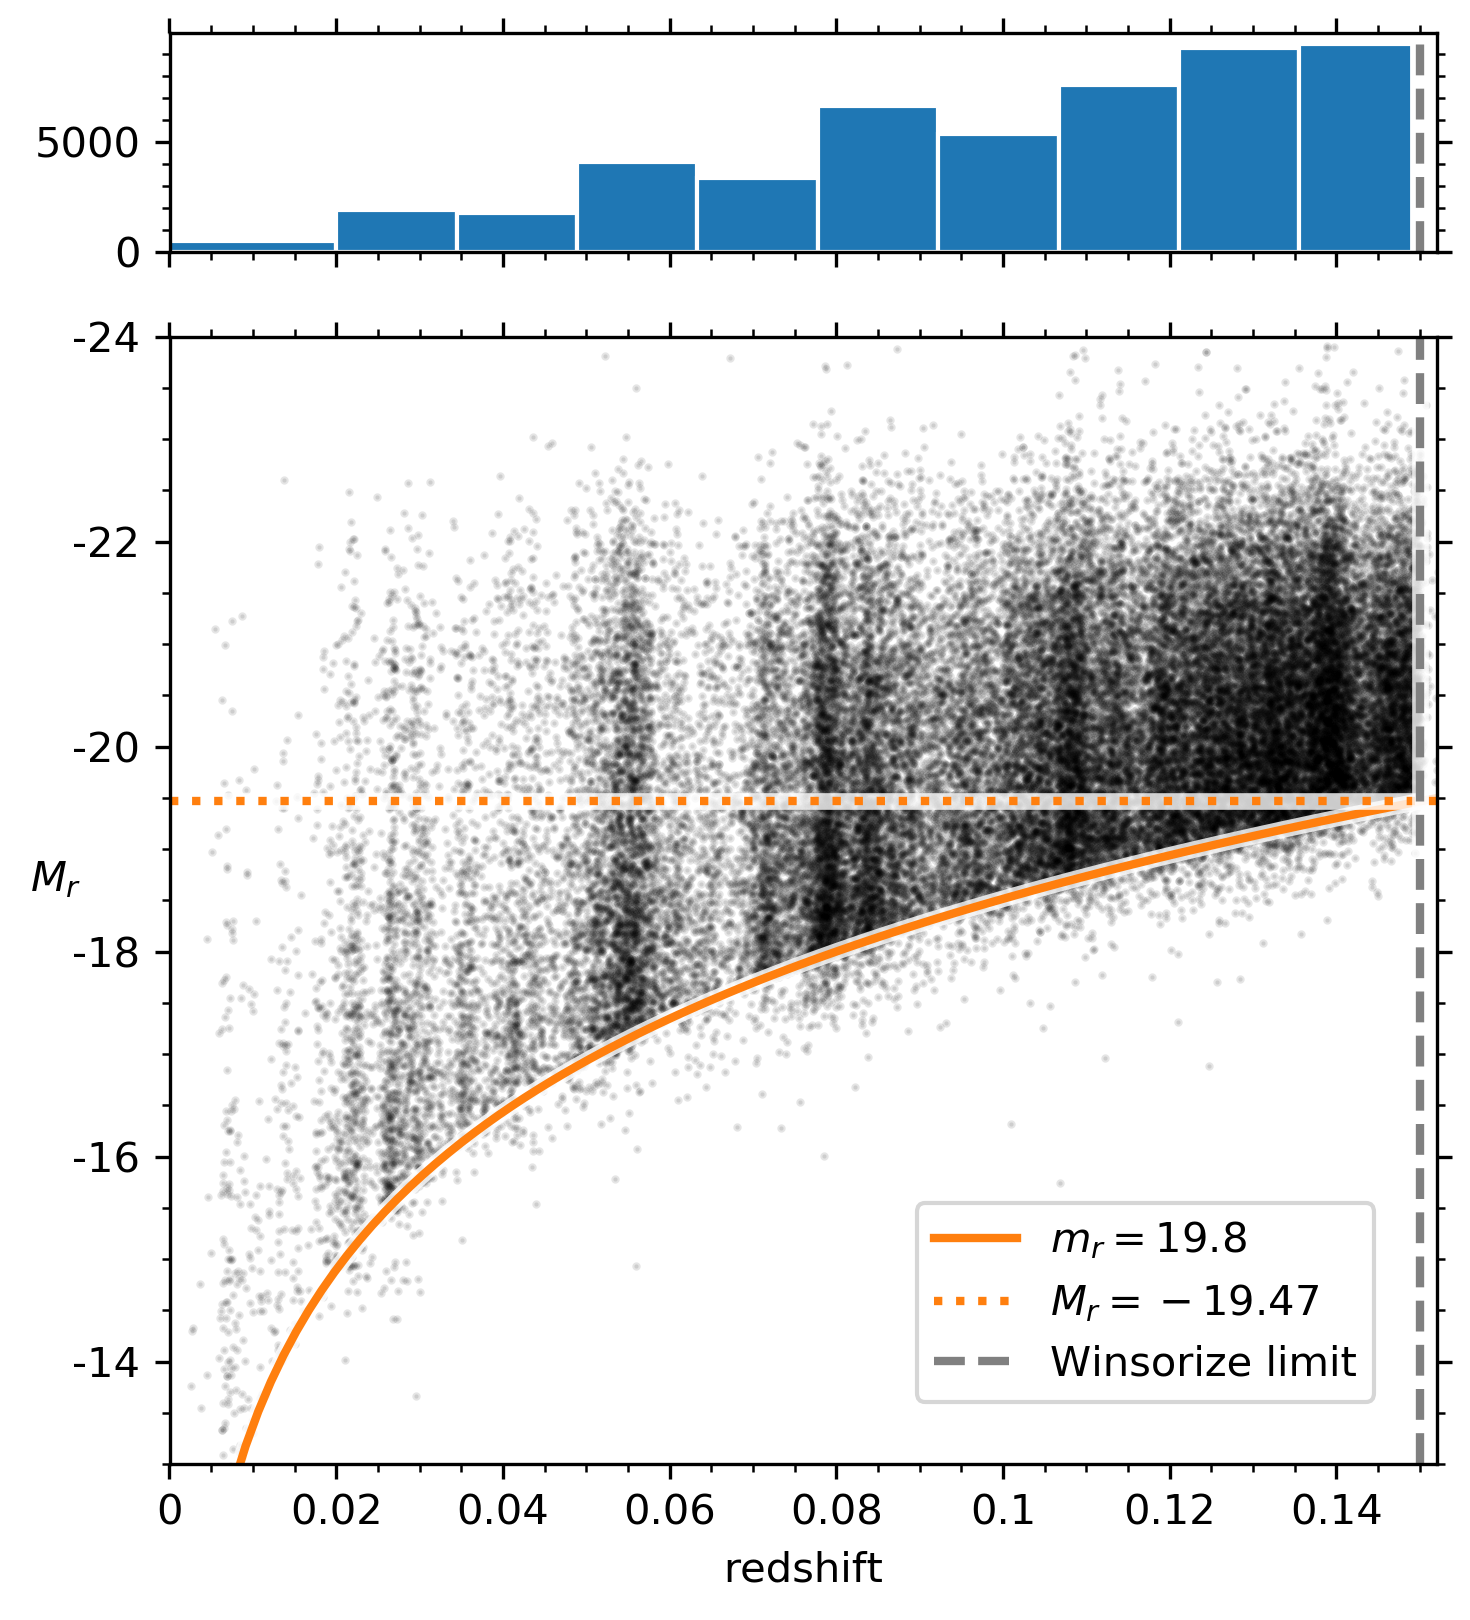

In [10]:
# redshift-magnitude plot
z = gama_ext[z_column]
mag = gama_ext[Mr_column]
winsorColor = 'grey'
outerZLim = [1e-5, volume_redshift_bounds[-1]+0.002]
magLim = [Mrhi, Mrlo]
outerMagLim = [magLim[0]+2, magLim[1]-1]
MagComplete = mag_to_Mag(survey_mag_limit,
                         np.max(volume_redshift_bounds))
lw = 2

fig = plt.figure(figsize=(5,5.5), dpi=dpi)
gs = matplotlib.gridspec.GridSpec(5, 1, figure=fig)
fmt = matplotlib.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))

ax = fig.add_subplot(gs[-4:,:])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
ax.scatter(z, mag, c='k', s=1, alpha=0.1, label='')
ax.set_xlabel('redshift')
ax.set_ylabel('$M_r$', rotation=0)
ax.set_xlim(outerZLim)
ax.set_ylim(outerMagLim)
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
zs = np.linspace(outerZLim[0], outerZLim[1], 101)
Mlims = mag_to_Mag(survey_mag_limit, zs)
ax.plot(zs, Mlims, c='w', lw=lw+2, label='', alpha=0.8)
ax.plot(zs, Mlims,c=cols[0],lw=lw,label=f'$m_r={survey_mag_limit}$')
ax.axhline(MagComplete, c='w', ls='solid', lw=lw+2,
           label='', alpha=0.8)
ax.axhline(MagComplete, c=cols[0], ls='dotted', lw=lw,
           label=f'$M_r={MagComplete:.02f}$')
ax.axvline(volume_redshift_bounds[-1], c='w', ls='solid', lw=lw+2,
           label='', alpha=0.8)
ax.axvline(volume_redshift_bounds[-1], c=winsorColor, ls='--',lw=lw,
           label='Winsorize limit')
ax.legend(loc='lower right', borderaxespad=1.5)

ax = fig.add_subplot(gs[:-4,:])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
histZBins = [0]+list(np.linspace(volume_redshift_bounds[0],
                                 volume_redshift_bounds[-1], 10))
if np.max(volume_redshift_bounds) < np.max(z):
    histZBins += [np.max(z)]
ax.hist(z, bins=histZBins, log=False, label='',
        edgecolor='white', color=cols[1])
ax.axvline(volume_redshift_bounds[-1],c='w',ls='-',lw=lw+3,label='')
ax.axvline(volume_redshift_bounds[-1],c=winsorColor,ls='--',lw=lw,
           label='Winsorize limit')
ax.set_xlim(outerZLim)
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.set_xticklabels([])

plt.tight_layout()
plt.savefig(fname=outdir+'/redshiftmag.png', dpi='figure')
plt.show()
plt.close()

In [11]:
# winsorize/trim/clip data to R50/Mr/z min/max ranges
R50 = gama_ext[R50_column]
Mr = gama_ext[Mr_column]
z = gama_ext[z_column]
R50_ok = np.all([R50 >= R50lo, R50 <= R50hi], axis=0)
Mr_ok = np.all([Mr >= Mrlo, Mr <= Mrhi], axis=0)
z_ok = np.all([z >= 0, z <= volume_redshift_bounds[-1]], axis=0)
data_ok = (R50_ok) & (Mr_ok) & (z_ok)
data[R50_column] = np.clip(data[R50_column], R50lo, R50hi)
data[Mr_column] = np.clip(data[Mr_column], Mrlo, Mrhi)
data[z_column]=np.clip(data[z_column],
                       volume_redshift_bounds[0],
                       volume_redshift_bounds[-1])
print(f'Winsorizing data in R50/Mr/z space')
print(f'  R50_ok: {sum(R50_ok)} / {len(R50_ok)} '
      f'({sum(~R50_ok)} winsorized)')
print(f'   Mr_ok: {sum(Mr_ok)} / {len(Mr_ok)} '
      f'({sum(~Mr_ok)} winsorized)')
print(f'    z_ok: {sum(z_ok)} / {len(z_ok)} '
      f'({sum(~z_ok)} winsorized)')
print(f'total_ok: {sum(data_ok)} / {len(data_ok)} '
      f'({sum(~data_ok)} winsorized)')

Winsorizing data in R50/Mr/z space
  R50_ok: 49213 / 49866 (653 winsorized)
   Mr_ok: 49425 / 49866 (441 winsorized)
    z_ok: 49792 / 49866 (74 winsorized)
total_ok: 48800 / 49866 (1066 winsorized)


## Question / Answer Dictionary

From Ross Hart: here, you can adjust what the questions are to be debiased, and their order. Note that the order does matter, you need to debias the questions further up the tree than the question you are currently debiasing.

In [12]:
# List of questions in order :
q = ['features',       # T00: smooth, features or star/artefact
     'edgeon',         # T01: edge on?
     'bar',            # T02: bar?
     'spiral',         # T03: spiral?
     'bulge',          # T04: face-on bulge prominence
     'spiralwinding',  # T05: arm winding
     'spiralnumber',   # T06: arm number
     'bulgeshape',     # T07: edge-on bulge shape
     'round',          # T08: roundedness
     'mergers',        # T09: merging or tidal debris
     'oddtype',        # T10: ring, lens, irr, other, dust, overlap
     'discuss',        # T11: discuss?
    ]

In [13]:
# Answers for each of the questions in turn:
a = [['smooth','features','star_or_artifact'],          # T00
     ['yes','no'],                                      # T01
     ['bar','no_bar'],                                  # T02
     ['spiral','no_spiral'],                            # T03
     ['no_bulge','obvious','dominant'],                 # T04
     ['tight','medium','loose'],                        # T05
     ['1','2','3','4','more_than_4'],                   # T06
     ['rounded','boxy','no_bulge'],                     # T07
     ['completely_round','in_between','cigar_shaped'],  # T08
     ['merging','tidal_debris','both','neither'],       # T09
     ['none','ring','lens_or_arc','irregular',
      'other','dust_lane','overlapping'],               # T10
     ['yes','no'],                                      # T11
    ]

In [14]:
# question labels
lbl_q = ['features',            # T00
         'edge-on',             # T01
         'bar',                 # T02
         'spiral arm',          # T03
         'bulge prominence',    # T04
         'spiral winding',      # T05
         'spiral arms',         # T06
         'bulge shape',         # T07
         'roundedness',         # T08
         'mergers',             # T09
         'odd features',        # T10
         'discuss',             # T11
        ]

In [15]:
# answer labels
lbl_a = [['smooth', 'featured', 'star/artefact'],             # T00
         ['edge-on', 'face-on/inclined'],                     # T01
         ['barred', 'unbarred'],                              # T02
         ['spiral arms', 'no spiral arms'],                   # T03
         ['no bulge', 'obvious bulge', 'dominant bulge'],     # T04
         ['tight spiral', 'moderate spiral', 
          'loose spiral'],                                    # T05
         ['1 arm', '2 arms', '3 arms', '4 arms', '5+ arms'],  # T06
         ['rounded bulge', 'boxy bulge', 'no bulge'],         # T07
         ['circular', 'in-between', 'cigar shaped'],          # T08
         ['merging', 'tidal debris', 
          'merging & tidal', 'no merging/tidal'],             # T09
         ['no odd features', 'ring', 'lens/arc', 
          'irregularity', 'other', 'dust lane', 'overlap'],   # T10
         ['discuss further', 'no discussion'],                # T11
        ]

In [16]:
# Required questions for each question in turn:
req_q = [None,     # T00
         [0],      # T01
         [0,1],    # T02
         [0,1],    # T03
         [0,1],    # T04
         [0,1,3],  # T05
         [0,1,3],  # T06
         [0,1],    # T07
         [0],      # T08
         [0],      # T09
         [0],      # T10
         None,     # T11
        ]

In [17]:
# Required answers for each previously answered question:
req_a = [None,     # T00
         [1],      # T01
         [1,1],    # T02
         [1,1],    # T03
         [1,1],    # T04
         [1,1,0],  # T05
         [1,1,0],  # T06
         [1,0],    # T07
         [0],      # T08
         None,     # T09
         None,     # T10
         None,     # T11
        ]

In [18]:
# Not-req answers: where req_a has multiple (req_q=[] & req_a=None)
not_a = [None,     # T00
         None,     # T01
         None,     # T02
         None,     # T03
         None,     # T04
         None,     # T05
         None,     # T06
         None,     # T07
         None,     # T08
         [2],      # T09
         [2],      # T10
         None,     # T11
        ]

In [19]:
# Put all of this together in a single question dict
question_dict = dict()
for s in range(len(q)):
    # setup possible answers and required questions
    if req_q[s] is not None:
        rq = [q[v] for v in req_q[s]] 
    else:
        rq = None
    question_dict[q[s]] = {'lbl_question': lbl_q[s],
                           'pos_answers': a[s],
                           'lbl_answers': lbl_a[s],
                           'req_questions': rq,}
    # add required answers
    if req_a[s] is not None:
        ra_array = [question_dict[q[v]]['pos_answers'] 
                    for v in req_q[s]]
        answer_arrays = [ra_array[v] 
                         for v in range(len(req_a[s]))]
        answer_indices = [req_a[s][v] 
                          for v in range(len(req_a[s]))]
        ra = [answer_arrays[v2][answer_indices[v2]] 
              for v2 in range(len(answer_indices))]
    else:
        ra = None # if there are no required questions
    question_dict[q[s]].update({'req_answers': ra})
    # add not-req answers (i.e., to be 1-p later on)
    if not_a[s] is not None:
        na_array = [question_dict[q[v]]['pos_answers']
                    for v in req_q[s]]
        answer_arrays = [na_array[v]
                         for v in range(len(not_a[s]))]
        answer_indices = [not_a[s][v]
                          for v in range(len(not_a[s]))]
        na = [answer_arrays[v2][answer_indices[v2]]
              for v2 in range(len(answer_indices))]
    else:
        na = None
    question_dict[q[s]].update({'not_answers': na})

In [20]:
# print questions dict
print(f'question_dict:\n**************\n')
for i, key in enumerate(question_dict):
    print(f'T{i:02} : {key}')
    display(question_dict[key])

question_dict:
**************

T00 : features


{'lbl_question': 'features',
 'pos_answers': ['smooth', 'features', 'star_or_artifact'],
 'lbl_answers': ['smooth', 'featured', 'star/artefact'],
 'req_questions': None,
 'req_answers': None,
 'not_answers': None}

T01 : edgeon


{'lbl_question': 'edge-on',
 'pos_answers': ['yes', 'no'],
 'lbl_answers': ['edge-on', 'face-on/inclined'],
 'req_questions': ['features'],
 'req_answers': ['features'],
 'not_answers': None}

T02 : bar


{'lbl_question': 'bar',
 'pos_answers': ['bar', 'no_bar'],
 'lbl_answers': ['barred', 'unbarred'],
 'req_questions': ['features', 'edgeon'],
 'req_answers': ['features', 'no'],
 'not_answers': None}

T03 : spiral


{'lbl_question': 'spiral arm',
 'pos_answers': ['spiral', 'no_spiral'],
 'lbl_answers': ['spiral arms', 'no spiral arms'],
 'req_questions': ['features', 'edgeon'],
 'req_answers': ['features', 'no'],
 'not_answers': None}

T04 : bulge


{'lbl_question': 'bulge prominence',
 'pos_answers': ['no_bulge', 'obvious', 'dominant'],
 'lbl_answers': ['no bulge', 'obvious bulge', 'dominant bulge'],
 'req_questions': ['features', 'edgeon'],
 'req_answers': ['features', 'no'],
 'not_answers': None}

T05 : spiralwinding


{'lbl_question': 'spiral winding',
 'pos_answers': ['tight', 'medium', 'loose'],
 'lbl_answers': ['tight spiral', 'moderate spiral', 'loose spiral'],
 'req_questions': ['features', 'edgeon', 'spiral'],
 'req_answers': ['features', 'no', 'spiral'],
 'not_answers': None}

T06 : spiralnumber


{'lbl_question': 'spiral arms',
 'pos_answers': ['1', '2', '3', '4', 'more_than_4'],
 'lbl_answers': ['1 arm', '2 arms', '3 arms', '4 arms', '5+ arms'],
 'req_questions': ['features', 'edgeon', 'spiral'],
 'req_answers': ['features', 'no', 'spiral'],
 'not_answers': None}

T07 : bulgeshape


{'lbl_question': 'bulge shape',
 'pos_answers': ['rounded', 'boxy', 'no_bulge'],
 'lbl_answers': ['rounded bulge', 'boxy bulge', 'no bulge'],
 'req_questions': ['features', 'edgeon'],
 'req_answers': ['features', 'yes'],
 'not_answers': None}

T08 : round


{'lbl_question': 'roundedness',
 'pos_answers': ['completely_round', 'in_between', 'cigar_shaped'],
 'lbl_answers': ['circular', 'in-between', 'cigar shaped'],
 'req_questions': ['features'],
 'req_answers': ['smooth'],
 'not_answers': None}

T09 : mergers


{'lbl_question': 'mergers',
 'pos_answers': ['merging', 'tidal_debris', 'both', 'neither'],
 'lbl_answers': ['merging',
  'tidal debris',
  'merging & tidal',
  'no merging/tidal'],
 'req_questions': ['features'],
 'req_answers': None,
 'not_answers': ['star_or_artifact']}

T10 : oddtype


{'lbl_question': 'odd features',
 'pos_answers': ['none',
  'ring',
  'lens_or_arc',
  'irregular',
  'other',
  'dust_lane',
  'overlapping'],
 'lbl_answers': ['no odd features',
  'ring',
  'lens/arc',
  'irregularity',
  'other',
  'dust lane',
  'overlap'],
 'req_questions': ['features'],
 'req_answers': None,
 'not_answers': ['star_or_artifact']}

T11 : discuss


{'lbl_question': 'discuss',
 'pos_answers': ['yes', 'no'],
 'lbl_answers': ['discuss further', 'no discussion'],
 'req_questions': None,
 'req_answers': None,
 'not_answers': None}

## Function & Inverse Function Dictionary

From Ross Hart: First we define the functions (and their respective inverses), then we construct a dictionary which lists all of the functions and bounds to be used in the to fit the data.

In [21]:
def f_logistic(x, k, c):
    # Function to fit the data bin output from the raw plot func.
    L = (1 + np.exp(c))
    r = L / (1.0 + np.exp(-k * x + c))
    return r

def f_exp_pow(x, k, c):
    # Function to fit the data bin output from the raw plot func.
    r = np.exp(-k * (-x) ** c)
    return r

def i_f_logistic(y, k, c):
    # inverse of f_logistic
    L = (1 + np.exp(c))
    x = -(np.log(L / y - 1) - c) / k
    return x

def i_f_exp_pow(y, k, c):
    # inverse of f_exp_pow
    k[np.isnan(k)] = 0
    ok = k > 0
    x = np.zeros_like(y) - np.inf
    logyok = (np.ma.log(y[ok]).filled(np.nan)).data
    x[ok] = -(-logyok / k[ok] )**(1.0 / c[ok])
    return x
function_dict = {}
function_dict['func'] = {0: f_logistic,
                         1: f_exp_pow,
                         }
function_dict['bounds'] = {0: logistic_bounds,
                           1: exponential_bounds,
                           }
function_dict['p0'] = {0: [3,-3],
                       1: [2,1],
                       }
function_dict['i_func'] = {0: i_f_logistic,
                           1: i_f_exp_pow,
                           }
function_dict['label'] = {0: 'logistic',
                          1: 'exp. power',
                          }

## Sampling Functions

This section provides methods which trim, bin and manipulate sample data.

In [22]:
# sample class: trims and manipulates data
class Sample():

    def __init__(self, full_data, question_dict, 
                 question='shape', p_cut=p_cut, N_cut=N_cut, 
                 use_normalised=False):
        logDat = np.log10(full_data[R50_column])-np.log10(R50lo)+1
        full_data['LOGR50'] = logDat
        if use_normalised == True:
            suffix = output_frac_suffix + '_norm'
        else:
            suffix = output_frac_suffix
        req_q = question_dict[question]['req_questions']
        req_a = question_dict[question]['req_answers']
        not_a = question_dict[question]['not_answers']
        if req_q is not None:
            p_col = np.ones(len(full_data))
            if req_a is not None:
                for q, a in zip(req_q, req_a):
                    p_col = (p_col * 
                             (full_data[q + '_' + a + suffix]))
            else:
                for q, a in zip(req_q, not_a):
                    p_col = (p_col * 
                             (1 - full_data[q + '_' + a + suffix]))
            N_col = full_data[question + input_total_suffix]
            select = (p_col >= p_cut) & (N_col >= N_cut)
            less_data = full_data[select]
            print(f'{len(less_data)}/{len(full_data)} galaxies '
                  f'with p>={p_cut} and N>={N_cut}.')
        else:
            less_data = full_data.copy()
            select = np.ones(len(full_data), dtype=np.bool)
            print(f'First tier question, so all {len(less_data)} '
                  f'galaxies used.')
        self.all_data = full_data
        self.less_data = less_data
        self.p_mask = select
        return None

    def volume_limited_sample(self):
        lower_z_limit = volume_redshift_bounds[0]
        upper_z_limit = volume_redshift_bounds[-1]
        mag_limit = survey_mag_limit
        Mag_limit = mag_to_Mag(mag_limit, upper_z_limit)
        in_vl = np.all([self.all_data[z_column] >= lower_z_limit,
                        self.all_data[z_column] <= upper_z_limit,
                        self.all_data[Mr_column] <= Mag_limit],
                        axis=0)
        self.in_volume_limit = in_vl
        self.Mag_limit = Mag_limit
        return in_vl

#     def z_slices(self):
#         in_vl = self.volume_limited_sample()        
#         lower_z_limits = [volume_redshift_bounds[0], 
#                           volume_redshift_bounds[1]]
#         upper_z_limits = [volume_redshift_bounds[-2], 
#                           volume_redshift_bounds[-1]]
#         in_lo_z = np.all([self.all_data[z_column] 
#                           >= lower_z_limits[0],
#                           self.all_data[z_column] 
#                           <= lower_z_limits[1]], 
#                          axis=0)
#         in_hi_z = np.all([self.all_data[z_column] 
#                           >= upper_z_limits[0],
#                           self.all_data[z_column] 
#                           <= upper_z_limits[1]], 
#                          axis=0)
#         return ((in_vl*in_lo_z).astype(bool), 
#                 (in_vl*in_hi_z).astype(bool))

In [23]:
# sample bin class
class Bins():

    def __init__(self, sample, 
                 question='shape', answer='smooth'):
        self.n_voronoi = n_voronoi
        self.n_per_z = n_per_z
        self.Mr = sample.less_data[Mr_column]
        self.R50 = sample.less_data['LOGR50']
        self.z = sample.less_data[z_column]
        self.Mr_all = sample.all_data[Mr_column]
        self.R50_all = sample.all_data['LOGR50']
        self.z_all = sample.all_data[z_column]
        self.n_min = low_signal_limit
        self.z_low_limit = volume_redshift_bounds[0]
        self.sample = sample
        self.question = question
        self.answer = answer
        savedir = outdir + question + answer
        self.savedir = savedir
        return None

    def voronoi_bin(self, save=False):
        Mr = self.Mr
        R50 = self.R50
        n_gal = len(Mr)
        n_rect_bins = (math.sqrt(n_gal)) / 2
        n_rect_bins = int(math.floor(n_rect_bins))
        n_per_voronoi_bin = n_gal / n_voronoi
        rect_bin_val,R50_bin_edges,Mr_bin_edges = np.histogram2d(
            R50, Mr, n_rect_bins)
        rect_bins_table = Table(data=[R50_bin_edges, Mr_bin_edges],
                                names=['R50_bin_edges', 
                                       'Mr_bin_edges'])
        # Get bin centres + number of bins:
        R50_bin_centres = 0.5*(R50_bin_edges[:-1] + 
                               R50_bin_edges[1:])
        Mr_bin_centres = 0.5*(Mr_bin_edges[:-1] + 
                              Mr_bin_edges[1:])
        n_R50_bins = len(R50_bin_centres)
        n_Mr_bins = len(Mr_bin_centres)
        # Get ranges:
        R50_bins_min, Mr_bins_min = map(np.min, (R50_bin_centres,
                                                 Mr_bin_centres))
        R50_bins_max, Mr_bins_max = map(np.max, (R50_bin_centres,
                                                 Mr_bin_centres))
        R50_bins_range = R50_bins_max - R50_bins_min
        Mr_bins_range = Mr_bins_max - Mr_bins_min
        # 'Ravel' out the coord bins (arr len = n_bin * n_bin)
        R50_bin_coords = R50_bin_centres.repeat(
            n_rect_bins).reshape(n_rect_bins,n_rect_bins).ravel()
        Mr_bin_coords = Mr_bin_centres.repeat(
            n_rect_bins).reshape(n_rect_bins,n_rect_bins).T.ravel()
        # Only keep bins that contain a galaxy:
        signal = rect_bin_val.ravel() # signal = number of gals.
        ok_bin = (signal > 0).nonzero()[0]
        signal = signal[ok_bin]
        # Normalise x + y to be between 0 and 1:
        x = ((R50_bin_coords[ok_bin] - R50_bins_min) / 
             R50_bins_range)
        y = ((Mr_bin_coords[ok_bin] - Mr_bins_min) / 
             Mr_bins_range)
        # Voronoi_2d_binning aims for a target S/N
        noise = np.sqrt(signal)
        targetSN = np.sqrt(n_per_voronoi_bin)
        output = voronoi_2d_binning(x, y, signal, noise, targetSN, 
                                    plot=0, quiet=True, wvt=True)
        binNum,xNode,yNode,xBar,yBar,sn,nPixels,scale = output
        vbin = np.unique(binNum)
        count = (sn**2).astype(np.int)
        R50_vbin_mean = (xBar * R50_bins_range + R50_bins_min)
        Mr_vbin_mean = (yBar * Mr_bins_range + Mr_bins_min)
        vbins_table = Table(data=[vbin, R50_vbin_mean, 
                                  Mr_vbin_mean,
                                  count, nPixels],
                            names=['vbin', 'R50', 'Mr', 
                                   'count_gals', 
                                   'count_rect_bins'])
        vbins_table.meta['nrectbin'] = n_rect_bins
        vbins_table.meta['nperbin'] = n_per_voronoi_bin
        # Populate rect. grid with voronoi bin indices and counts
        rect_bin_voronoi_bin = (
            np.zeros(np.product(rect_bin_val.shape), np.int)- 1)
        rect_bin_voronoi_bin[ok_bin] = binNum
        rect_vbins_table = Table(data=[R50_bin_coords, 
                                       Mr_bin_coords,
                                       rect_bin_voronoi_bin],
                                 names=['R50', 'Mr', 'vbin'])
        rect_bins_table.meta['nrectbin'] = n_rect_bins
        rect_bins_table.meta['nperbin'] = n_per_voronoi_bin
        if save == True:
            if os.path.isdir(outdir) is False:
                os.mkdir(outdir)
            if os.path.isdir(outdir + '/' + question) is False:
                os.mkdir(outdir + '/' + question)
            if os.path.isdir(savedir) is False:
                os.mkdir(savedir)
            rect_bins_table.write(
                self.savedir + '/rect_bins_table.fits',
                overwrite=True)
            vbins_table.write(
                self.savedir + '/vbins_table.fits',
                overwrite=True)
            rect_vbins_table.write(
                self.savedir + '/rect_vbins_table.fits',
                overwrite=True)
        rect_vbins_table['R50_norm'] = (
            rect_vbins_table['R50'] - R50_bins_min)/R50_bins_range
        rect_vbins_table['Mr_norm'] = (
            rect_vbins_table['Mr'] - Mr_bins_min)/Mr_bins_range
        self.rect_bins_table = rect_bins_table
        self.vbins_table = vbins_table
        self.rect_vbins_table = rect_vbins_table
        self.Mr_bins_min = Mr_bins_min
        self.Mr_bins_range = Mr_bins_range
        self.R50_bins_min = R50_bins_min
        self.R50_bins_range = R50_bins_range
        return None

    def voronoi_assignment(self, reassign=True):
        '''Assign each of the galaxies a voronoi bin. If 
           reassign is True, then even the galaxies not in the 
           sample are given a voronoi bin.'''
        Mr_all = self.Mr_all
        R50_all = self.R50_all
        z_all = self.z_all
        rect_bins_table = self.rect_bins_table 
        rect_vbins_table = self.rect_vbins_table
        vbins_table = self.vbins_table
        Mr_bins_min = self.Mr_bins_min
        Mr_bins_range = self.Mr_bins_range
        R50_bins_min = self.R50_bins_min
        R50_bins_range = self.R50_bins_range
        # Load outputs from the 'voronoi_binning' module:
        R50_bin_edges = rect_bins_table['R50_bin_edges']
        Mr_bin_edges = rect_bins_table['Mr_bin_edges']
        n_R50_bins = len(R50_bin_edges) - 1
        n_Mr_bins = len(Mr_bin_edges) - 1
        # Get the R50 and Mr bin for each galaxy in the sample
        R50_bins = np.digitize(R50_all, 
                               bins=R50_bin_edges).clip(1, 
                                                        n_R50_bins)
        Mr_bins = np.digitize(Mr_all, 
                              bins=Mr_bin_edges).clip(1, 
                                                      n_Mr_bins)
        self.rect_vbins_table = rect_vbins_table
        # convert R50 and Mr bin indices to indices of bins
        # in the combined rectangular grid
        rect_bins = (Mr_bins - 1) + n_Mr_bins * (R50_bins - 1)
        # get the voronoi bin for each galaxy in the sample
        rect_bin_vbins = rect_vbins_table['vbin']
        voronoi_bins = rect_bin_vbins[rect_bins]
        in_p = self.sample.p_mask
        if reassign is True:
            for v in np.unique(voronoi_bins[in_p]):
                in_v = voronoi_bins[in_p] == v
                if in_v.sum() <= self.n_min:
                    voronoi_bins[voronoi_bins == v] = -1
            assigned = voronoi_bins >= 0
            if (assigned == False).sum() != 0:
                xy = np.array([(R50_all - R50_bins_min) / 
                               R50_bins_range,
                              (Mr_all - Mr_bins_min) / 
                               Mr_bins_range]).T
                nbrs = NearestNeighbors(
                    n_neighbors=1).fit(xy[assigned])
                d, i = nbrs.kneighbors(xy[assigned == False])
                voronoi_bins[assigned == False] = voronoi_bins[
                    assigned][i.squeeze()]
        self.voronoi_bins = voronoi_bins
        return None
    
    def redshift_assignment(self):
        '''Bin each of the voronoi bins in terms in to bins of 
           equal sample sizes, each with >=min_gals galaxies.'''
        n_per_bin = self.n_per_z
        q = self.question
        a = self.answer
        z_bins = np.zeros(len(self.z_all),dtype=np.int)
        for v in np.unique(self.voronoi_bins):
            in_v = self.voronoi_bins == v
            in_p = self.sample.p_mask
            in_q = self.sample.all_data[
                q + '_' + a + input_frac_suffix] > 0
            in_vpq = np.all([in_v, in_p, in_q],axis=0)
            z_v = self.z_all[in_v]
            in_vpq &= self.z_all > self.z_low_limit
            z_vpq = self.z_all[in_vpq]
            n_zbins = np.max([5, int(math.floor(in_vpq.sum() / 
                                                self.n_per_z))])
            z_vpq = np.sort(z_vpq)
            bin_edges = np.linspace(0, len(z_vpq)-1, n_zbins+1, 
                                    dtype=np.int)
            z_edges = z_vpq[bin_edges]
            z_edges[0] -= 1
            z_edges[-1] += 1
            z_bins_v = np.digitize(z_v, z_edges)
            z_bins[in_v] = z_bins_v
        self.z_bins = z_bins
        # put all objects below low z limit in a 'zero' bin
        #self.z_bins[self.z_all < self.z_low_limit] = 0
        return None

## Fitting Functions

This section provides fitting routines.

In [24]:
class FunctionFit():

    def __init__(self, question, answer):
        self.question = question
        self.answer = answer
        self.parameter_table = Table(names=('logR50','Mr','z',
                                            'k','c','chisq',
                                            'success'))

    def chisq_fun(self,p, f, x, y):
        ''' chisquare function'''
        return ((f(x, *p) - y)**2).sum()

    def cumfrac_fit(self, data, function_, append=True):
        q = self.question
        a = self.answer
        fv = np.sort(data[q + '_' + a + input_frac_suffix])
        fv_nonzero = fv != 0
        cf = np.linspace(0,1,len(fv))
        x, y = [np.log10(fv[fv_nonzero]),cf[fv_nonzero]]
        x_fit = np.log10(np.linspace(10**(log_fv_range[0]), 1, 
                                     100))
        indices = np.searchsorted(x,x_fit)
        y_fit = y[indices.clip(0, len(y)-1)]
        fit_setup = function_
        res = minimize(self.chisq_fun, function_.p0,
                       args=(function_.function, x_fit, y_fit),
                       bounds=function_.bounds)
        #, method='SLSQP')
        Mr = np.mean(data[Mr_column])
        logR50 = np.mean(data['LOGR50'])
        z_ = np.mean(data[z_column])
        k, c = res.x
        if append is True:
            row = [logR50,Mr,z_,k,c,res.fun,res.success]
            self.parameter_table.add_row(row)
        return None

In [25]:
class Function():

    def __init__(self, function_dict, key):
        self.function = function_dict['func'][key]
        self.bounds = function_dict['bounds'][key]
        self.p0 = function_dict['p0'][key]
        self.inverse_function = function_dict['i_func'][key]
        self.label = function_dict['label'][key]    

In [26]:
class FitToBins():

    def __init__(self, functionfit, column='k', clip_percentile=5):
        self.fit_table = functionfit.parameter_table
        self.Mr = self.fit_table['Mr']
        self.R50 = self.fit_table['logR50']
        self.z = self.fit_table['z']
        self.fit_parameter = self.fit_table[column]
        self.ok_fit = self.fit_table['success'] == 1
        self.column = column
        if clip_percentile is not None:
            parameter_mean = np.mean(self.fit_parameter)
            parameter_std = np.std(self.fit_parameter)
            parameter_min = np.percentile(self.fit_parameter,
                                          clip_percentile)
            parameter_max = np.percentile(self.fit_parameter,
                                          100-clip_percentile)
            self.in_sigma = np.all([self.fit_parameter
                                    >= parameter_min,
                                    self.fit_parameter
                                    <= parameter_max],
                                   axis=0)
        else:
            self.in_sigma = np.full(len(parameter_table),True)
        to_fit = np.all([self.ok_fit,self.in_sigma], axis=0) 
        self.to_fit = to_fit
        # Set limits of the functions here:
        self.min_ = self.fit_parameter[to_fit].min() 
        self.max_ = self.fit_parameter[to_fit].max()

    def kc_function(self,M_dependence,R_dependence,z_dependence):
        def kcfunc(x,A0,AM,AR,Az):
            M_term = self.get_term(AM,x[0],M_dependence,
                                   negative=True)
            R_term = self.get_term(AR,x[1],R_dependence)
            z_term = self.get_term(Az,x[2],z_dependence)
            return A0 + M_term + R_term + z_term
        return kcfunc

    def get_term(self,constant,var,t='linear',negative='False'):
        if negative is True:
            var = -var
        if t == 'log':
            newvar = np.array((np.ma.log10(var).filled(np.nan)))
            term = constant*newvar
        elif t == 'linear':
            term = constant*var
        elif t == 'exp':
            term = constant*(10**(var))
        return term

    def get_MRz_function(self,M_dependence,R_dependence,
                         z_dependence):
        def kcfunc(x,A0,AM,AR,Az):
            M_term = get_term(AM,x[0],M_dependence)
            R_term = get_term(AR,x[1],R_dependence)
            z_term = get_term(Az,x[2],z_dependence)
            return A0 + M_term + R_term + z_term
    
        return kcfunc

    def normalise(self,x):
        return (x - x.mean()) / x.std()

    def get_kc_function(self, verbose=True):
        M_dependencies = ('log','linear','exp')
        R_dependencies = ('log','linear','exp')
        z_dependencies = ('log','linear','exp')
        # Find the best functions for fitting the data:
        output_table = Table(names=('M_dependency','R_dependency',
                                    'z_dependency','p_fit',
                                    'chisq'),
                             dtype=('object','object',
                                    'object','object',
                                    np.float32))
        for M_dependency in M_dependencies:
            for R_dependency in R_dependencies:
                for z_dependency in z_dependencies:
                    kcfunc = self.kc_function(M_dependency,
                                              R_dependency,
                                              z_dependency)
                    p_fit, res, _ = self.fit_mrz(kcfunc)
                    MRz_row = [M_dependency,R_dependency,
                               z_dependency,p_fit,res]
                    output_table.add_row(MRz_row)
        # Set nan values very large (so they are auto. avoided!)
        output_table['chisq'][np.isfinite(
            output_table['chisq']) == False] = 10**8
        # Choose best functions:
        best_row = np.argmin(output_table['chisq']) 
        best_M_d = output_table['M_dependency'][best_row]
        best_R_d = output_table['R_dependency'][best_row]
        best_z_d = output_table['z_dependency'][best_row]
        kcfunc = self.kc_function(best_M_d,best_R_d,best_z_d)
        if verbose is True:
            print(f'--- Selected function ({self.column}): ---')
            print(f'{best_M_d}(M),{best_R_d}(R),{best_z_d}(z)')
        p_fit, _, fitted_table = self.fit_mrz(kcfunc)
        self.kc_function = kcfunc
        self.p_fit = p_fit
        self.output_table = output_table
        self.fitted_table = fitted_table
        return self

    def fit_mrz(self, kc_function, clip=None):
        '''Fit a linear function of M, R and z to k and c.'''
        x = self.Mr
        y = self.R50
        z = self.z
        xyz = np.array([x,y,z])
        fitted_table = Table(xyz.T,names=('Mr','R50','z'))
        fitted_table[self.column] = self.fit_parameter
        xyz_ok = (xyz.T[self.to_fit]).T
        fit_parameter_ok = self.fit_parameter[self.to_fit]
        # Fit to the data:
        p_fit, _ = curve_fit(kc_function,xyz_ok,
                             fit_parameter_ok,maxfev=10**5)  
        res = (kc_function(xyz_ok,*p_fit) - 
               fit_parameter_ok) # k residuals
        res_normalised = self.normalise(res) # norm. k residuals
        # Remove the +-2sigma fits, and then redo the fitting:
        if clip != None:
            clipped = np.absolute(res_normalised) < clip 
            p_fit, _ = curve_fit(kc_function, 
                                 (xyz_ok.T[clipped]).T, 
                                 fit_parameter_ok[clipped],
                                 maxfev=10**5)
        fitted_table[self.column + '_fit'] = kc_function(xyz,
                                                         *p_fit)
        chisq = (fitted_table[self.column+'_fit'] - 
                 fitted_table[self.column])**2
        return p_fit, chisq.sum(), fitted_table

In [27]:
def fit_bins(sample, bins, function_dict,
             question='shape', answer='smooth', verbose=True):
    log_function = Function(function_dict,0)
    exp_function = Function(function_dict,1)
    logfit = FunctionFit(question, answer)
    expfit = FunctionFit(question, answer)
    v_unique = np.unique(bins.voronoi_bins)
    for v in v_unique:
        in_v = bins.voronoi_bins[sample.p_mask] == v
        z_unique = np.unique(bins.z_bins[sample.p_mask][in_v])
        # ignore the 'zero' bin
        z_unique = z_unique[z_unique > 0]
        for z in z_unique:
            in_z = bins.z_bins[sample.p_mask] == z
            in_vz = np.all([in_v,in_z],axis=0)
            logfit.cumfrac_fit(sample.less_data[in_vz],
                               log_function)
            expfit.cumfrac_fit(sample.less_data[in_vz],
                               exp_function)
    chisq_log = np.sum(logfit.parameter_table['chisq'])
    chisq_exp = np.sum(expfit.parameter_table['chisq'])
    if verbose is True:
        print(f'------------------')
        print(f'chisq (log) = {round(chisq_log.sum(),1)}')
        print(f'chisq (exp) = {round(chisq_exp.sum(),1)}')
        print(f'------------------')
    if chisq_log < chisq_exp:
        print('=> log func preferred') if verbose is True else None
        return logfit, log_function, logistic_bounds
    else:
        print('=> exp func preferred') if verbose is True else None
        return expfit, exp_function, exponential_bounds

In [28]:
def debias_data(sample, fitted_k, fitted_c, function_,
                question='shape', answer='smooth'):
    data = sample.less_data
    function = function_.function
    inverse_function = function_.inverse_function
    fv_column = question + '_' + answer + input_frac_suffix
    fv = data[fv_column]
    fv_debiased = np.zeros(len(fv))
    nonzero = fv > 0
    fv_nonzero = fv[nonzero]
    logfv = np.log10(fv_nonzero)
    x = data[Mr_column][nonzero]
    y = data['LOGR50'][nonzero]
    z = data[z_column][nonzero]
# LSK change - this functionality moved to Winsorize section at top
#     low_z_limit = volume_redshift_bounds[0]
#     # treat redshift below low_z_limit as if they were at
#     # the low_z_limit, i.e. no debiasing
#     z = z.clip(low_z_limit)
    xyz = np.array([x,y,z])
    xyz_low_z = xyz.copy()
    xyz_low_z[-1] = np.full(len(z), volume_redshift_bounds[0])

    def fitted_parameter(xyz, f):
        p = f.kc_function(xyz,*f.p_fit)
        # p[p <= f.min_] = f.min_
        # p[p >= f.max_] = f.max_
        p = np.clip(p, f.min_, f.max_)
        return p

    k = fitted_parameter(xyz,fitted_k)
    k_low_z = fitted_parameter(xyz_low_z,fitted_k)
    c = fitted_parameter(xyz,fitted_c)
    c_low_z = fitted_parameter(xyz_low_z,fitted_c)
    cumfrac = function(logfv, k, c)
    logfv_debiased = np.array(inverse_function(cumfrac, 
                                               k_low_z, 
                                               c_low_z))
    debiased = 10**(logfv_debiased) # Get 'fv'.
    fv_debiased[nonzero] = debiased
    fv_output = np.zeros(len(sample.all_data))
    fv_output[sample.p_mask] = fv
    fv_debiased_output = np.zeros(len(sample.all_data)) + null_value
    fv_debiased_output[sample.p_mask] = fv_debiased
    if np.max(fv) > 1:
        import IPython; IPython.embed()
    if np.max(fv_debiased) > 1:
        import IPython; IPython.embed()
    return fv_output, fv_debiased_output

In [29]:
# This module does the abundance matching on a bin-by-bin basis,
# depending on the bins provided from the binning.py module.
def find_nearest(reference, values):
    '''Given an array (reference), return the indices of the 
       closest indices for for each of the numbers in the array 
       "values".'''
    i = np.zeros(len(values))
    for m,value in enumerate(values):
        i[m] = (np.abs(reference-value)).argmin()
    return i.astype(int)

In [30]:
def sort_data(D):
    '''Sort data by a given column, to get a cumulative fraction 
       for each index of an array.'''
    D_i = np.arange(len(D))
    order = np.argsort(D)
    D_sorted = D[order]
    D_i_sorted = D_i[order]
    cumfrac = np.linspace(0,1,len(D))
    D_table = Table(np.array([D_i_sorted,D_sorted,cumfrac]).T,
                    names=('index','fv','cumfrac'))
    reorder = np.argsort(D_table['index'])
    D_table = D_table[reorder]
    for f in np.unique(D_table['fv']):
        f_select = D_table['fv'] == f
        D_table['cumfrac'][f_select] = np.mean(
            D_table['cumfrac'][f_select])
    return D_table

In [31]:
def debias_by_bin(sample, vbins, zbins, question, answer):
    ''' Debias the data in a bin-by-bin basis'''
    # Get the raw and debiased fractions:
    fraction_column = question + '_' + answer + input_frac_suffix
    # using only appropriate galaxies
    data_column = sample.less_data[fraction_column]
    vbins = vbins[sample.p_mask]
    zbins = zbins[sample.p_mask]
    debiased_column = np.zeros(len(data_column))
    for v in np.unique(vbins):
        select_v = vbins == v
        zbins_v = zbins[select_v] # this voronoi bin redshift bins
        data_v0 = data_column[(select_v) & (zbins == 1)]
        v0_table = sort_data(data_v0) # Ref. array
        # (ie. the low-z sample for each voronoi bin).
        for z in np.unique(zbins_v): # go through each bin in turn:
            select_z = zbins == z
            data_vz = data_column[(select_v) & (select_z)] 
            if z == 0:
                # do not debias objects below the low z limit
                debiased_column[(select_v) & 
                                (select_z)] = data_vz
            else:
                vz_table = sort_data(data_vz)
                # Now match to the low redshift sample:
                debiased_i = find_nearest(v0_table['cumfrac'],
                                          vz_table['cumfrac'])
                debiased_fractions = v0_table['fv'][debiased_i]
                debiased_column[(select_v) & 
                                (select_z)] = debiased_fractions
    debiased_column[data_column == 0] = 0 # Don't 'debias up' 0s.
    debiased_column[data_column == 1] = 1 # Don't 'debias down' 1s.
    debiased_output = np.zeros(len(sample.all_data)) + null_value
    debiased_output[sample.p_mask] = debiased_column
    return debiased_output

## Debias Functions

The functions in this section facilitate debiasing for a single question/answer pair.

In [32]:
# bin data function
def bin_values(values, nbins, fixedcount=True):
    '''Bin the data by value (e.g., into redshift slices).'''
    sorted_indices = np.argsort(values)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        x = np.empty(len(values))
        x[sorted_indices] = np.linspace(0, 1, len(values))
        bins = np.digitize(x, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(values), np.max(values), 
                                nbins + 1)
        bin_edges[-1] += 1
        x = values
        bins = np.digitize(x, bins=bin_edges)
    stat, be, bn = binned_statistic(x, values, bins=bin_edges)
    return stat, bins

In [33]:
# return histogram fractions
def histogram_fractions(a, bins):
    '''Get raw histogram values .'''
    hist, bin_edges = np.histogram(a, bins=bins)
    f = hist / np.sum(hist)
    return f

In [34]:
# calculate RMS of a dataset in comp. w. ref. data
def get_chi2(dataset, reference, redshifts):
    '''Calculate RMS of a dataset in comparison w. ref. data.'''
    bins = np.linspace(0,1,11)
    bins[0] = -1
    bins[-1] = 2
    zv, zb = bin_values(redshifts, nbins=10)
    rms_values = np.zeros(len(np.unique(zb)))
    ref_fractions = histogram_fractions(reference, bins)
    for i, z in enumerate(np.unique(zb)):
        sample = dataset[zb == z]
        fractions = histogram_fractions(sample, bins)
        rms_values[i] = np.sum((fractions-ref_fractions)**2)
    return np.sum(rms_values)

In [35]:
# primary debiasing function
def debias(data, question='features', answer='smooth', 
           use_fit=False, use_bin=False, append_column=True, 
           verbose=True):
    data_sample = Sample(data, question_dict, question)
    bins = Bins(data_sample, question, answer)
    bins.voronoi_bin()
    bins.voronoi_assignment(reassign=True)
    bins.redshift_assignment()
    # bin by bin...
    fv_debiased_bin = debias_by_bin(data_sample,
                                    bins.voronoi_bins,
                                    bins.z_bins,
                                    question, answer)
    functionfit, function_, bounds = fit_bins(data_sample,
                                              bins,
                                              function_dict,
                                              question,
                                              answer,
                                              verbose=verbose)
    # function fitter...
    fitted_k = FitToBins(functionfit,'k',
                         clip_percentile).get_kc_function(
        verbose=verbose)
    fitted_c = FitToBins(functionfit,'c',
                         clip_percentile).get_kc_function(
        verbose=verbose)
    fv, fv_debiased = debias_data(data_sample,
                                  fitted_k,fitted_c,function_,
                                  question,answer)
    fv_debiased[np.isfinite(fv_debiased) == False] = 0
    
    # AT THIS POINT fv, fv_debiased AND fv_debiased_bin CONTAIN
    # AN ENTRY FOR EVERY GALAXY, BUT THOSE THAT DON'T FALL IN
    # THE 'VALID' SAMPLE ARE SET EQUAL TO A FLAG VALUE OF null_value
    
    if use_fit is True:
        fv_debiased_final = fv_debiased
    elif use_bin is True:
        fv_debiased_final = fv_debiased_bin
    else:
        # need to check which is better - need a vol limited sample
        in_vl = data_sample.volume_limited_sample()
        # need to limit to the 'valid' sample here, especially
        # if we have not added the 'uncorrected' values back in
        in_vl &= data_sample.p_mask
        z = data_sample.all_data[z_column]
        chi2_bin = get_chi2(fv_debiased_bin[in_vl],
                            fv[in_vl],z[in_vl])
        chi2_fit = get_chi2(fv_debiased[in_vl],
                            fv[in_vl],z[in_vl])
        if chi2_bin < chi2_fit:
            print('bin method preferred')
            fv_debiased_final = fv_debiased_bin
        else:
            print('fit method preferred')
            fv_debiased_final = fv_debiased
        if verbose is True:
            print(f'---------')
            print(f'chi2 (bin) = {np.round(chi2_bin,2)}')
            print(f'chi2 (fit) = {np.round(chi2_fit,2)}')
            print(f'---------')
    # give back the outputs...
    if append_column is True:
        data[question+'_'+answer+
             output_frac_suffix]=fv_debiased_final
        return data
    else:
        return fv, fv_debiased_final

## Run Debiasing Code

Finally, run debiasing routines on all input data

In [36]:
# set up question check list
# NB: to run a low-tier question, all prior req_q must also be run
questions = [q for q in question_dict.keys()]
# questions = ['features','edgeon','spiral','spiralnumber']
# questions = ['features', 'edgeon']
# questions = ['features']
data_deb = data.copy()

# GIVEN THAT BIN METHOD TYPICALLY PREFERRED, OR SIMILAR CHISQ,
# TO FIT METHOD - PLUS SO MUCH SIMPLER, AND WE HAVEN'T INSPECTED
# THE REASONABLENESS OF THE FITS - COULD PERHAPS ALWAYS USE
# BIN METHOD WITH use_bin=True

for q in questions:
    answers = question_dict[q]['pos_answers']
    for a in answers:
        print(f'\n\n\n{"-"*68}')
        print(f'Q: {q}')
        print(f'A: {a}')
        print(f'{"-"*68}')
        data_deb = debias(data_deb,question=q,answer=a,verbose=True)




--------------------------------------------------------------------
Q: features
A: smooth
--------------------------------------------------------------------
First tier question, so all 49866 galaxies used.
Bin-accretion...
464  initial bins.
Reassign bad bins...
25  good bins.
Modified Lloyd algorithm...
23  iterations.
Unbinned pixels:  0  /  6366
Fractional S/N scatter (%): 18.192099143348962
------------------
chisq (log) = 315.2
chisq (exp) = 189.8
------------------
=> exp func preferred
--- Selected function (k): ---
linear(M),linear(R),log(z)
--- Selected function (c): ---
exp(M),log(R),log(z)
bin method preferred
---------
chi2 (bin) = 1.63
chi2 (fit) = 1.68
---------



--------------------------------------------------------------------
Q: features
A: features
--------------------------------------------------------------------
First tier question, so all 49866 galaxies used.
Bin-accretion...
464  initial bins.
Reassign bad bins...
25  good bins.
Modified Lloyd algorith

7  iterations.
Unbinned pixels:  0  /  545
Fractional S/N scatter (%): 23.422523265301376
------------------
chisq (log) = 26.8
chisq (exp) = 20.1
------------------
=> exp func preferred
--- Selected function (k): ---
linear(M),log(R),exp(z)
--- Selected function (c): ---
log(M),log(R),log(z)
bin method preferred
---------
chi2 (bin) = 0.25
chi2 (fit) = 0.45
---------



--------------------------------------------------------------------
Q: spiralwinding
A: medium
--------------------------------------------------------------------
6733/49866 galaxies with p>=0.5 and N>=5.
Bin-accretion...
40  initial bins.
Reassign bad bins...
28  good bins.
Modified Lloyd algorithm...
7  iterations.
Unbinned pixels:  0  /  545
Fractional S/N scatter (%): 23.422523265301376
------------------
chisq (log) = 27.5
chisq (exp) = 22.1
------------------
=> exp func preferred
--- Selected function (k): ---
log(M),log(R),log(z)
--- Selected function (c): ---
log(M),exp(R),log(z)
bin method preferred
------

------------------
chisq (log) = 57.2
chisq (exp) = 26.9
------------------
=> exp func preferred
--- Selected function (k): ---
linear(M),log(R),exp(z)
--- Selected function (c): ---
exp(M),log(R),exp(z)
fit method preferred
---------
chi2 (bin) = 0.04
chi2 (fit) = 0.04
---------



--------------------------------------------------------------------
Q: round
A: cigar_shaped
--------------------------------------------------------------------
13370/49866 galaxies with p>=0.5 and N>=5.
Bin-accretion...
138  initial bins.
Reassign bad bins...
23  good bins.
Modified Lloyd algorithm...
15  iterations.
Unbinned pixels:  0  /  1791
Fractional S/N scatter (%): 14.734809392610293
------------------
chisq (log) = 7.3
chisq (exp) = 1.4
------------------
=> exp func preferred
--- Selected function (k): ---
linear(M),log(R),linear(z)
--- Selected function (c): ---
exp(M),log(R),log(z)
fit method preferred
---------
chi2 (bin) = 0.05
chi2 (fit) = 0.04
---------



-------------------------------

--- Selected function (c): ---
linear(M),log(R),log(z)
fit method preferred
---------
chi2 (bin) = 0.22
chi2 (fit) = 0.14
---------



--------------------------------------------------------------------
Q: discuss
A: yes
--------------------------------------------------------------------
First tier question, so all 49866 galaxies used.
Bin-accretion...
464  initial bins.
Reassign bad bins...
25  good bins.
Modified Lloyd algorithm...
23  iterations.
Unbinned pixels:  0  /  6366
Fractional S/N scatter (%): 18.192099143348962
------------------
chisq (log) = 19.5
chisq (exp) = 14.4
------------------
=> exp func preferred
--- Selected function (k): ---
log(M),exp(R),log(z)
--- Selected function (c): ---
linear(M),linear(R),log(z)
fit method preferred
---------
chi2 (bin) = 1.45
chi2 (fit) = 0.58
---------



--------------------------------------------------------------------
Q: discuss
A: no
--------------------------------------------------------------------
First tier question, so a

/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


--- Selected function (k): ---
log(M),log(R),exp(z)
--- Selected function (c): ---
log(M),linear(R),log(z)
fit method preferred
---------
chi2 (bin) = 1.56
chi2 (fit) = 1.12
---------


## Dataset Clean Up

 * Construct reference sample prior p columns
 * Trim final dataset of unnecessary columns
 * write into output FITS table
 * GZIP

In [37]:
# generate prior p column data
q_keys = [q for q in question_dict.keys()]
for q in q_keys:
    
    # pick out question/answer info
    rqs = question_dict[q]['req_questions']
    ras = question_dict[q]['req_answers']
    nas = question_dict[q]['not_answers']
    
    # choose only those that had pq>=0.5 and Nq>=5 for req_q/req_a
    if rqs is not None:
        pq = 1
        if ras is not None:
            for q_, a_ in zip(rqs, ras):
                colname = f'{q_}_{a_}{output_frac_suffix}'
                pq *= data_deb[colname]
        else:
            for q_, a_ in zip(rqs, nas):
                colname = f'{q_}_{a_}{output_frac_suffix}'
                pq *= (1 - data_deb[colname])
        Nq = data_deb[f'{q}{input_total_suffix}']
    else:
        pq = 1
        Nq = 100
    req_good = (pq >= 0.5) & (Nq >= 5)
    
    # add column
    newcolname = q + output_priorsample_suffix
    data_deb[newcolname] = req_good
    data_deb[q+'_pq'] = pq

In [38]:
# remove duplicated and unnecessary columns in final catalogue
data_deb_trim = data_deb.copy()
bin_names = [c for c in data_deb_trim.colnames if 
             input_frac_suffix in c]
bad_names = (bin_names + 
             [Mr_column, R50_column, z_column] + 
             ['LOGR50'])
data_deb_trim.remove_columns(bad_names)

In [39]:
# write output catalogue and gzip
if output_cat[-3:] == '.gz':
    output_cat_TEMP = output_cat[:-3]
    if os.path.exists(output_cat_TEMP):
        os.remove(output_cat_TEMP)
    if os.path.exists(output_cat):
        os.remove(output_cat)
    data_deb_trim.write(output_cat_TEMP)
    cmd = f'gzip --best {output_cat_TEMP}'
    !{cmd}
else:
    if os.path.exists(output_cat):
        os.remove(output_cat)
    data_deb_trim.write(output_cat)

In [40]:
# analyse debiased data for given question
display(data_deb[z_column,
                 'features_clean_total',
                 'features_deb_psamp',
                 'features_smooth_clean_frac',
                 'features_smooth_deb_frac',
                 'features_features_clean_frac',
                 'features_features_deb_frac',
                 'features_star_or_artifact_clean_frac',
                 'features_star_or_artifact_deb_frac',
                ].to_pandas().head(5).T)

,0,1,2,3,4
Z_TONRY,0.148279,0.108523,0.144015,0.134939,0.0339111
features_clean_total,24.2226,30.2618,24.8368,30.8754,24.0721
features_deb_psamp,True,True,True,True,True
features_smooth_clean_frac,0.886983,0.825104,0.905504,0.760679,0.209065
features_smooth_deb_frac,0.393442,0.159458,0.606882,0.311211,0.059056
features_features_clean_frac,0.0718199,0.0874997,0.0197019,0.177423,0.411941
features_features_deb_frac,0.687442,0.773196,0.271709,0.565175,0.628926
features_star_or_artifact_clean_frac,0.0411973,0.0873968,0.0747939,0.0618975,0.378994
features_star_or_artifact_deb_frac,0.0219545,0.063453,0.0748624,0.03229,0.390885


In [41]:
# analyse debiased data for given question
display(data_deb[z_column,
                 Mr_column,
                 R50_column,
                 'features_features_deb_frac',
                 'edgeon_clean_total',
                 'edgeon_pq',
                 'edgeon_deb_psamp',
                 'edgeon_yes_clean_frac',
                 'edgeon_yes_deb_frac',
                 'edgeon_no_clean_frac',
                 'edgeon_no_deb_frac',
                ].to_pandas().iloc[1:1+5,:].T)

,1,2,3,4,5
Z_TONRY,0.108523,0.144015,0.134939,0.0339111,0.0787542
absmag_r,-19.8786,-19.555,-19.7078,-16.2429,-18.7449
GALRE_r_kpc,2.86407,1.91554,5.55965,1.71198,3.64581
features_features_deb_frac,0.773196,0.271709,0.565175,0.628926,0.705261
edgeon_clean_total,2.6479,0.489333,5.47801,9.91628,2.6083
edgeon_pq,0.773196,0.271709,0.565175,0.628926,0.705261
edgeon_deb_psamp,False,False,True,True,False
edgeon_yes_clean_frac,0.0641626,0.488426,0.182548,0.0482041,0
edgeon_yes_deb_frac,-1,-1,0.11219,0.0439725,-1
edgeon_no_clean_frac,0.935837,0.511574,0.817452,0.951796,1


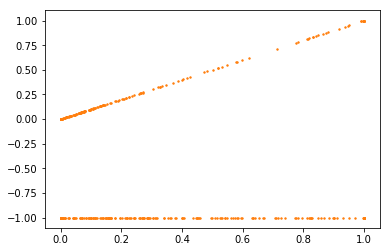

In [42]:
samp = (data_deb[z_column]<volume_redshift_bounds[0])
ax = plt.subplot(111)
# ax.scatter(data_deb['edgeon_yes_clean_frac'],
#            data_deb['edgeon_yes_deb_frac'],
#            color=cols[1], s=1)
ax.scatter(data_deb['edgeon_yes_clean_frac'][samp],
           data_deb['edgeon_yes_deb_frac'][samp],
           color=cols[0], s=2)
#ax.set_xlim((0,1))
#ax.set_ylim((0,1))

In [43]:
vals = (data_deb['edgeon_yes_clean_frac'][samp] -
        data_deb['edgeon_yes_deb_frac'][samp])
print(sum(vals == 0))
print(len(vals))
print(sum(vals==0) / len(vals))

184
473
0.3890063424947146


23360
49866


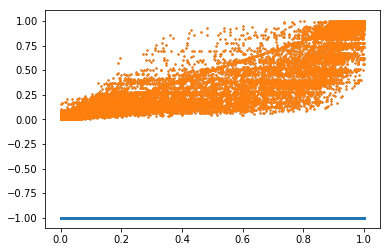

In [44]:
samp = (data_deb['edgeon_deb_psamp']==1)
ax = plt.subplot(111)
ax.scatter(data_deb['edgeon_yes_clean_frac'],
           data_deb['edgeon_yes_deb_frac'],
           color=cols[1], s=1)
ax.scatter(data_deb['edgeon_yes_clean_frac'][samp],
           data_deb['edgeon_yes_deb_frac'][samp],
           color=cols[0], s=2)
# ax.set_xlim((0,1))
# ax.set_ylim((0,1))
print(sum(samp))
print(len(samp))

23360
49866


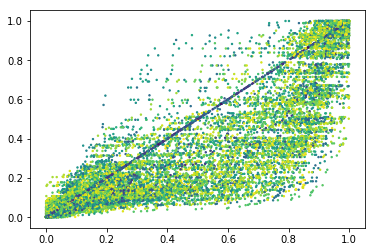

In [45]:
samp = (data_deb['edgeon_deb_psamp']==1)
ax = plt.subplot(111)
ax.scatter(data_deb['edgeon_yes_clean_frac'][samp],
           data_deb['edgeon_yes_deb_frac'][samp],
           c=data_deb['Z_TONRY'][samp], s=2)
# ax.set_xlim((0,1))
# ax.set_ylim((0,1))
print(sum(samp))
print(len(samp))

7449
49866


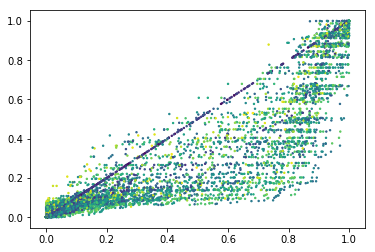

In [46]:
samp = (data_deb['edgeon_deb_psamp']==1) & (data_deb['absmag_r']>=-19.54) # & (data_deb['Z_TONRY']< 0.050)
ax = plt.subplot(111)
ax.scatter(data_deb['edgeon_yes_clean_frac'][samp],
           data_deb['edgeon_yes_deb_frac'][samp],
           c=data_deb['Z_TONRY'][samp], s=2)
# ax.set_xlim((0,1))
# ax.set_ylim((0,1))
print(sum(samp))
print(len(samp))

4209
49866


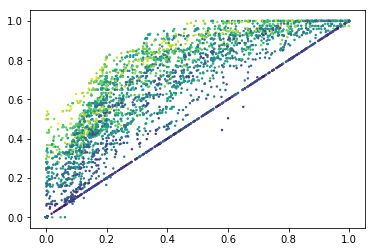

In [47]:
samp = (data_deb['spiral_deb_psamp']==1) & (data_deb['absmag_r']>=-19.54) & (data_deb['Z_TONRY']< 0.5)
ax = plt.subplot(111)
ax.scatter(data_deb['spiral_spiral_clean_frac'][samp],
           data_deb['spiral_spiral_deb_frac'][samp],
           c=data_deb['Z_TONRY'][samp], s=2)
# ax.set_xlim((0,1))
# ax.set_ylim((0,1))
print(sum(samp))
print(len(samp))

## Debiased Trends Plots for p>0.5

Primary analysis plot showcasing debiasing outputs.

In [82]:
# plot setup
Mag_limit = mag_to_Mag(survey_mag_limit, volume_redshift_bounds[-1])
print(f'abs mag limit: {Mag_limit}')
in_vl = np.all([data_deb[z_column] >= volume_redshift_bounds[0],
                data_deb[z_column] <= volume_redshift_bounds[-1],
                data_deb[Mr_column] < Mag_limit],
               axis=0)
zbins = np.linspace(volume_redshift_bounds[0],
                    volume_redshift_bounds[1],
                    11)
zlos = zbins[:-1]
zhis = zbins[1:]
# cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
# cols[0],cols[1] = cols[1],cols[0]
# cols = 'rbgkmcy'

abs mag limit: -19.46597275573048


In [83]:
q_keys = [q for q in question_dict.keys()]
q_labels = [question_dict[x]['lbl_question'] for x in question_dict]
q = q_keys[0]
lq = q_labels[0]
las = question_dict[q]['lbl_answers']
pas = question_dict[q]['pos_answers']
rqs = question_dict[q]['req_questions']
ras = question_dict[q]['req_answers']
nas = question_dict[q]['not_answers']
if rqs is not None:
    pq = 1
    if ras is not None:
        for q_, a_ in zip(rqs, ras):
            pq *= data_deb[f'{q_}_{a_}{output_frac_suffix}']
    else:
        for q_, a_ in zip(rqs, nas):
            pq *= (1-data_deb[f'{q_}_{a_}{output_frac_suffix}'])
    Nq = data_deb[f'{q}{input_total_suffix}']
else:
    pq = 1
    Nq = 100
req_good = (pq > 0.5) & (Nq >= 5) & (in_vl)
a = pas[0]
la = las[0]
col = cols[0]
zs = data_deb[z_column][req_good]
fb = data_deb[f'{q}_{a}{input_frac_suffix}'][req_good]>0.5
fd = data_deb[f'{q}_{a}{output_frac_suffix}'][req_good]>0.5

In [89]:
len(zmids)

10

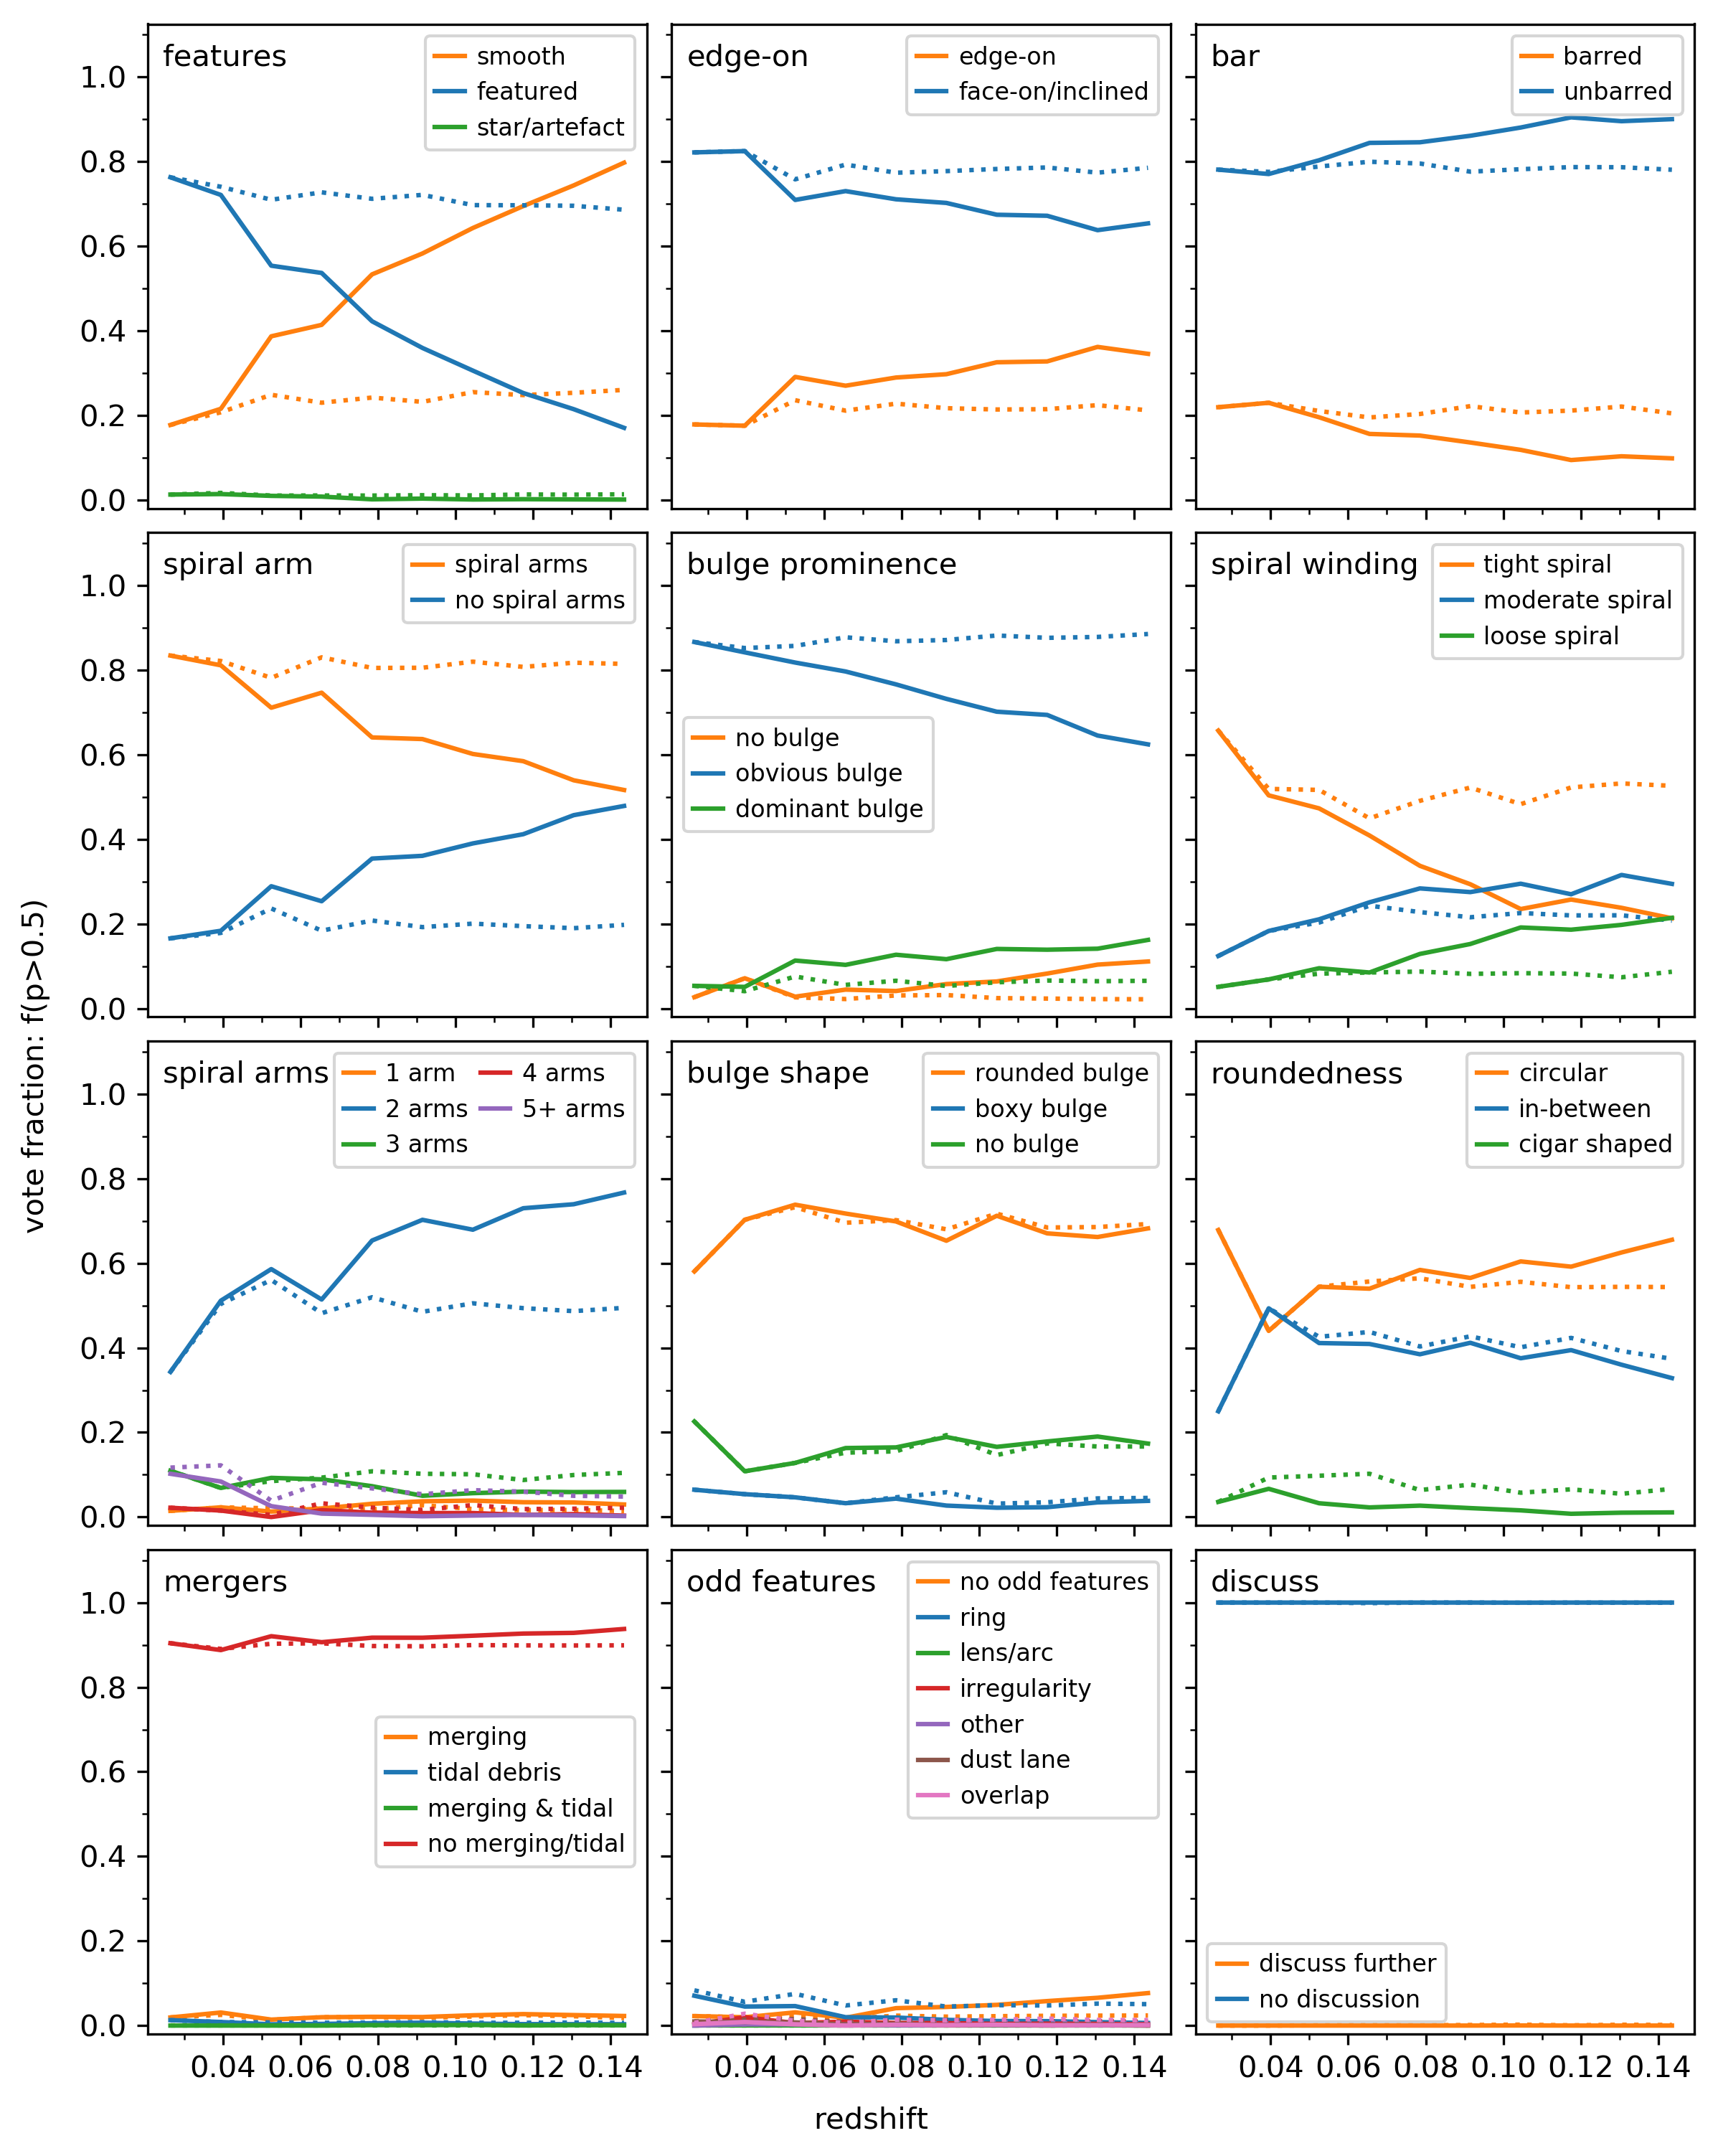

In [86]:
# setup figure
fig, axs = plt.subplots(4, 3, figsize=(8,10), dpi=dpi, 
                        sharex=True, sharey=True)

# loop over each question
q_keys = [q for q in question_dict.keys()]
q_labels = [question_dict[x]['lbl_question'] for x in question_dict]
for q, lq, ax in zip(q_keys, q_labels, axs.flatten()):
    
    # tick marks
    ax.set_xticks(np.arange(0,0.2,0.02))
    ax.set_yticks(np.arange(0,1.01,0.2))
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.01))
    ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.1))
    
    # pick out question/answer info
    las = question_dict[q]['lbl_answers']
    pas = question_dict[q]['pos_answers']
    rqs = question_dict[q]['req_questions']
    ras = question_dict[q]['req_answers']
    nas = question_dict[q]['not_answers']
    
    # choose only those that had pq>0.5 and Nq>5 for req_q/req_a
    if rqs is not None:
        pq = 1
        if ras is not None:
            for q_, a_ in zip(rqs, ras):
                pq *= data_deb[f'{q_}_{a_}{output_frac_suffix}']
        else:
            for q_, a_ in zip(rqs, nas):
                pq *= (1-data_deb[f'{q_}_{a_}{output_frac_suffix}'])
        Nq = data_deb[f'{q}{input_total_suffix}']
    else:
        pq = 1
        Nq = 100
    req_good = (pq > 0.5) & (Nq >= 5) & (in_vl)
    
    # loop over each answer and plot lines
    for a, la, col in zip(pas, las, cols):
        
        # fb=frac before debiasing, fd=frac after debiasing
        zs = data_deb[z_column][req_good]
        fb = data_deb[f'{q}_{a}{input_frac_suffix}'][req_good]>0.5
        fd = data_deb[f'{q}_{a}{output_frac_suffix}'][req_good]>0.5
        
        # loop over each redshift bin
        passb = np.array([])
        passd = np.array([])
        total = np.array([])
        zmids = np.array([])
        for zlo, zhi in zip(zlos, zhis):
            zgood = (zs > zlo) & (zs <= zhi)
            passb = np.append(passb, sum(fb & zgood))
            passd = np.append(passd, sum(fd & zgood))
            total = np.append(total, sum(zgood))
            zmids = np.append(zmids, np.mean((zlo,zhi)))
        
        # plot
        ax.plot(zmids, passb/total, color=col, ls='-', label=la)
        ax.plot(zmids, passd/total, color=col, ls=':')
        ax.set_ylim(-0.02, 1.125)
    
    # add label and legend
    ax.text(0.03, 0.96, lq, transform=ax.transAxes, 
           fontsize=10, va='top', ha='left')
    if (q=='spiral' or q=='bulge' or q=='discuss' or 
        q=='mergers' or q=='bulgeshape'):
        legpos = 'best'
    else:
        legpos = 'upper right'
    
    if q=='spiralnumber':
        ax.legend(loc=legpos, fontsize=8, ncol=2, 
                  handlelength=1.25, handletextpad=0.5, 
                  columnspacing=0.5)
    else:
        ax.legend(loc=legpos, fontsize=8, ncol=1, 
                  handlelength=1.25, handletextpad=0.5)

fig.tight_layout()
fig.subplots_adjust(hspace=0.05, wspace=0.05, 
                    left=0.08, bottom=0.05)
fig.text(0.5, 0.01, 'redshift', 
         fontsize=10, va='center', ha='center')
fig.text(0.015, 0.5, 'vote fraction: f(p>0.5)', 
         fontsize=10, va='center', ha='center', rotation=90)

# plt.savefig(plot_votefrac)
plt.show()
plt.close()

## Vote Distribution Histograms

Vote distribution histograms for each of the answers.

In [50]:
# # # file clean
# # if os.path.exists(plot_votefrac):
# #     os.remove(plot_votefrac)

# # # setup figure
# # fig, axs = plt.subplots(4, 3, figsize=(8,10), dpi=dpi, 
# #                         sharex=True, sharey=True)

# # loop over each question
# q_keys = [q for q in question_dict.keys()]
# q_labels = [question_dict[x]['lbl_question'] for x in question_dict]
# # for q, lq, ax in zip(q_keys, q_labels, axs.flatten()):
# for q, lq in zip(q_keys, q_labels):
    
# #     # tick marks
# #     ax.set_xticks(np.arange(0,0.2,0.02))
# #     ax.set_yticks(np.arange(0,1.01,0.2))
# #     ax.minorticks_on()
# #     ax.xaxis.set_minor_locator(
# #         matplotlib.ticker.MultipleLocator(0.01))
# #     ax.yaxis.set_minor_locator(
# #         matplotlib.ticker.MultipleLocator(0.1))
    
#     # pick out question/answer info
#     las = question_dict[q]['lbl_answers']
#     pas = question_dict[q]['pos_answers']
#     rqs = question_dict[q]['req_questions']
#     ras = question_dict[q]['req_answers']
#     nas = question_dict[q]['not_answers']
    
#     # choose only those that had pq>0.5 and Nq>5 for req_q/req_a
#     if rqs is not None:
#         pqf = 1
#         pqd = 1
#         if ras is not None:
#             for q_, a_ in zip(rqs, ras):
#                 pqf *= data_deb[f'{q_}_{a_}_frac']
#                 pqd *= data_deb[f'{q_}_{a_}_debiased']
#         else:
#             for q_, a_ in zip(rqs, nas):
#                 pqf *= (1 - data_deb[f'{q_}_{a_}_frac'])
#                 pqd *= (1 - data_deb[f'{q_}_{a_}_debiased'])
#         Nq = data_deb[f'{q}_total']
#     else:
#         pqf = 1
#         Nq = 100
#     req_good_frac = (pqf > 0.5) & (Nq >= 5) & (in_vl)

## Conclusions

This notebook successfully debiases GAMA-KiDS Galaxy Zoo data using the procedures outlined in Hart et al. 2016. Final results are presented in the figure above, with original (raw/binned) data shown using solid lines, and debiased data shown using dotted lines.

In [51]:
# Notebook finish up
nbt1 = time.time()
nbt1str = time.strftime(nbtf, time.localtime(nbt1))
nbtd = nbt1-nbt0
nbtdstr = time.strftime('%H:%M:%S', time.gmtime(nbtd))
print(f'Notebook end time: \n   {nbt1str} (elapsed: {nbtdstr})')
#--------------------------------68-------------------------------->

Notebook end time: 
   2020-10-09 18:08:48 CDT (elapsed: 00:09:54)
